In [1]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np

def nothing(x):
    pass

# Load image
image = cv2.imread('pose.jpg')

# Create a window
cv2.namedWindow('image')

# Create trackbars for color change
# Hue is from 0-179 for Opencv
cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# Set default value for Max HSV trackbars
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize HSV min/max values
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

while(1):
    # Get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin', 'image')
    sMin = cv2.getTrackbarPos('SMin', 'image')
    vMin = cv2.getTrackbarPos('VMin', 'image')
    hMax = cv2.getTrackbarPos('HMax', 'image')
    sMax = cv2.getTrackbarPos('SMax', 'image')
    vMax = cv2.getTrackbarPos('VMax', 'image')

    # Set minimum and maximum HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Convert to HSV format and color threshold
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(image, image, mask=mask)

    # Print if there is a change in HSV value
    if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display result image
    cv2.imshow('image', result)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

error: OpenCV(4.5.2) /tmp/pip-req-build-oxjbfc17/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)

# hsv
image = cv2.imread('pose.jpg')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([56, 35, 100])
upper = np.array([80, 130, 255])
mask = cv2.inRange(hsv, lower, upper)
result = cv2.bitwise_and(image, image, mask=mask)

# gray
h, s, v1 = cv2.split(result)

kernel = np.ones((2,2),np.uint8)
erosion = cv2.erode(v1,kernel,iterations = 1)

kernel = np.ones((10, 10), np.uint8)
closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)

binary = np.where(closing>0, 1, closing)

p = []
hight = 0.05/10
for i in range(binary.shape[0]):
    for j in range(binary.shape[1]):
        if binary[i][j]==1:
            a = (-i + 468) * 1/450
            b = (j - 73) * 1/450
            p.append([b, a])
p = np.array(p)

In [2]:
add_p = 10000 - len(p)
random_count = add_p // len(p)

In [3]:
add_p_list = []
for i in p:
    add_p_list.append(i)
    random_p = np.random.uniform(low=-0.003, high=0.003, size=(random_count, 2)) + i
    for j in range(random_count):
        add_p_list.append(random_p[j])
add_p_list = np.array(add_p_list)

In [4]:
from sklearn.cluster import DBSCAN
particle_x_num = 48
origin=[-459, 77]
center = [223, 255]
sim_unit_aruco2sim = 0.0019569471624266144

rope_perticle_list = []
for i in range(binary.shape[0]):
    for j in range(binary.shape[1]):
        if binary[int(i)][int(j)]==1:
            y = (-i - origin[0])
            y = (y - center[0])/2
            y *= sim_unit_aruco2sim
            x = (j - origin[1])
            x = (x - center[1])/2
            x *= sim_unit_aruco2sim
            rope_perticle_list.append([x, y])
rope_perticle = np.array(rope_perticle_list)

clustering = DBSCAN(eps=0.01, min_samples=9).fit(rope_perticle)
labels = clustering.labels_

counts = np.bincount(labels)
sums_x = np.bincount(labels, rope_perticle[:, 0])
sums_y = np.bincount(labels, rope_perticle[:, 1])
means_x = sums_x/counts
means_y = sums_y/counts
res = np.polyfit(means_x, means_y, 20)

base_x = []
rope_length_dx_r = (np.max(means_x) - np.median(means_x))/particle_x_num
rope_length_dx_l = (np.median(means_x) - np.min(means_x))/particle_x_num
base_x_l = base_x_r = np.median(means_x)
base_x.append(np.median(means_x))
for _ in range(particle_x_num):
    base_x_r += rope_length_dx_r
    base_x.append(base_x_r)
    base_x_l -= rope_length_dx_l
    base_x.append(base_x_l)
base_y = np.poly1d(res)(base_x)

/home/robot_dev4/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


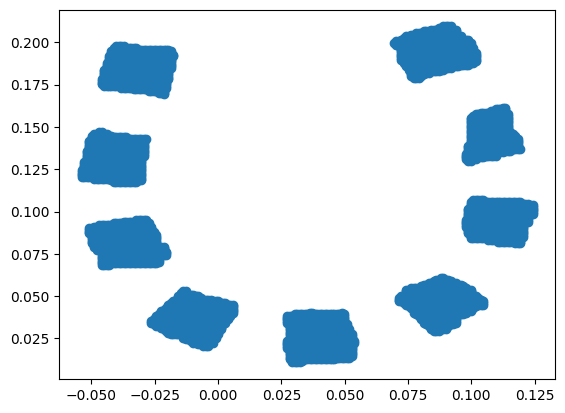

In [5]:
plt.scatter(rope_perticle[:, 0], rope_perticle[:, 1])

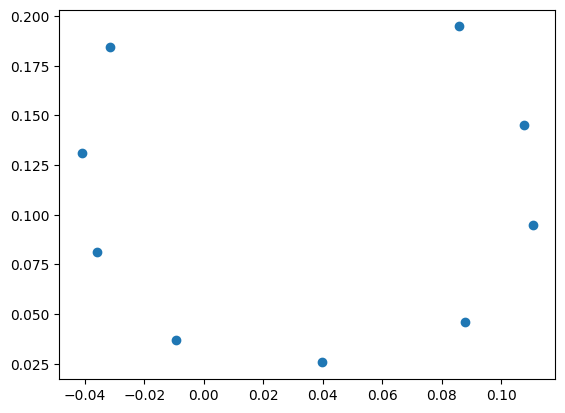

In [6]:
plt.scatter(means_x, means_y)

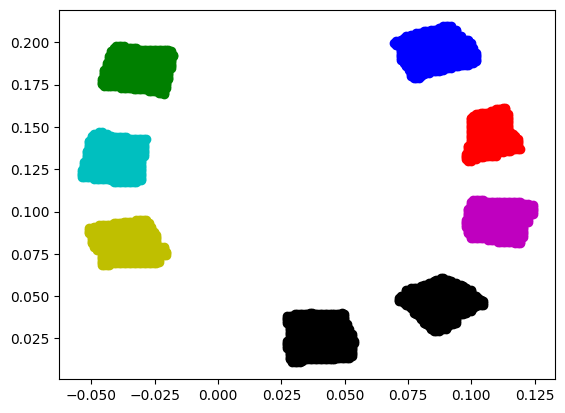

In [7]:
cmap = {0: 'b', 1: 'g', 2: 'r', 3: 'c', 4: 'm', 5: 'y', 6: 'k', 7: 'w', 8: 'k'}
fig, ax = plt.subplots()
for i in range(len(labels)):
    ax.scatter(rope_perticle[i, 0], rope_perticle[i, 1], color=cmap[labels[i]])
plt.show()

In [234]:
import cv2
import numpy as np
import datetime
from PIL import Image
import alphashape
from descartes import PolygonPatch

In [193]:
goal_state = np.load(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/tasks/multi_bc_rope/imgs/v1500/goal_state.npy')
goal_state = goal_state[:, [0, 2]]

In [28]:
goal = np.load(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/plb/envs/assets/multi_bc_rope-v1401.npy')

In [ ]:
goal = np.load(f'x.npy')
n_grid = 64
new_goal_state = []
for i in range(n_grid):
    for j in range(n_grid):
        for k in range(n_grid):
            if goal[i][j][k] < 0.000:
                new_goal_state.append([i/n_grid, j/n_grid, k/n_grid])
goal_state = np.array(new_goal_state)

In [13]:
import pickle
with open('/home/robot_dev4/kuroki/DMLC/policy/pbm/experts/Rope-v3/point_list_11:11:40.txt', 'rb') as f:
    data = pickle.load(f)

/home/robot_dev4/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


IndexError: list index out of range

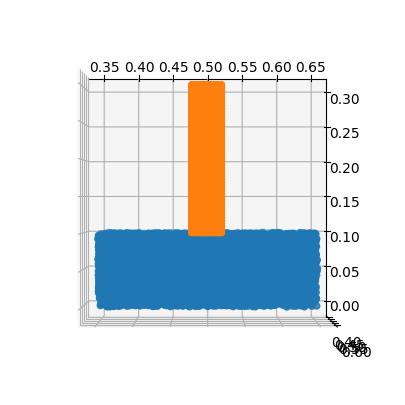

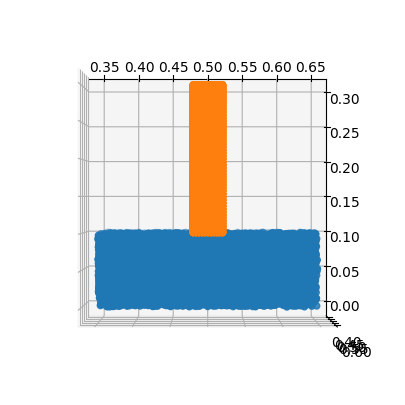

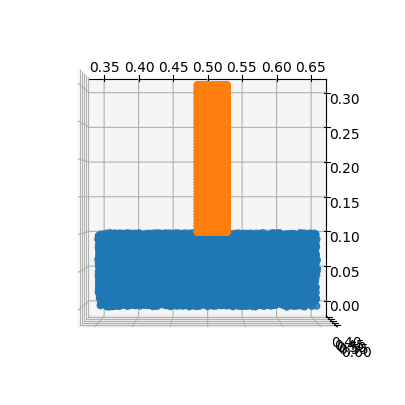

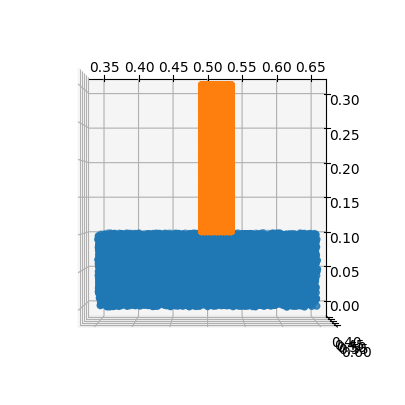

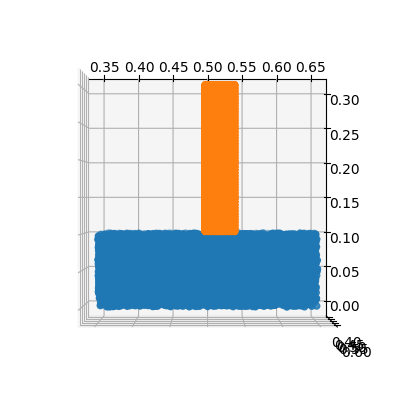

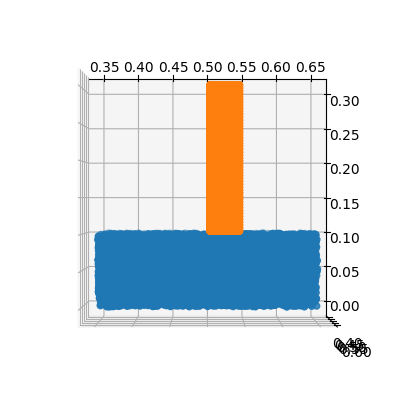

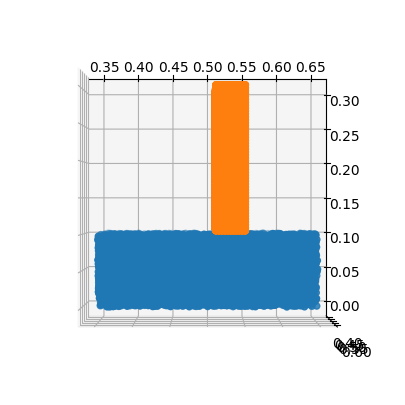

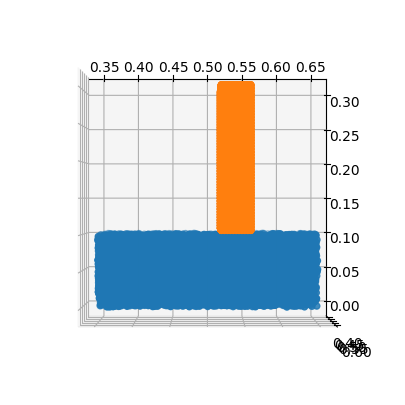

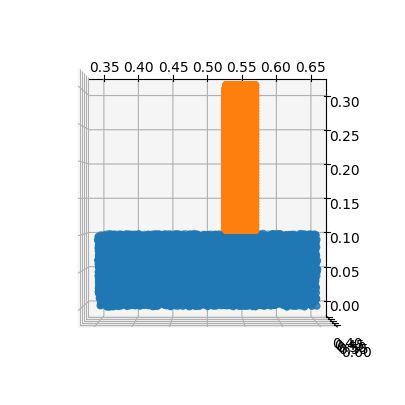

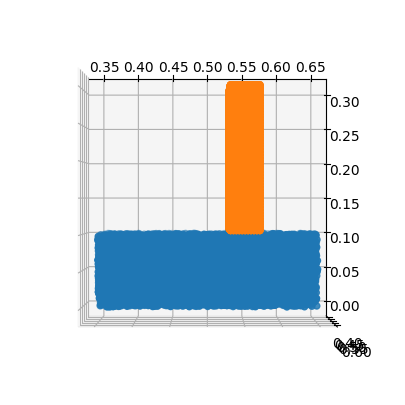

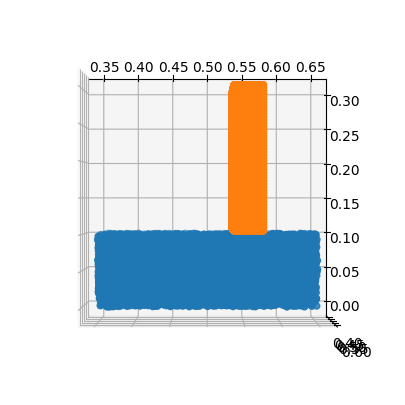

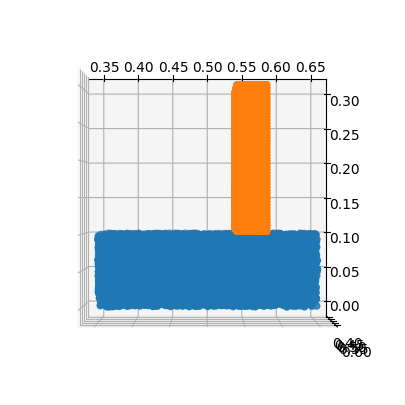

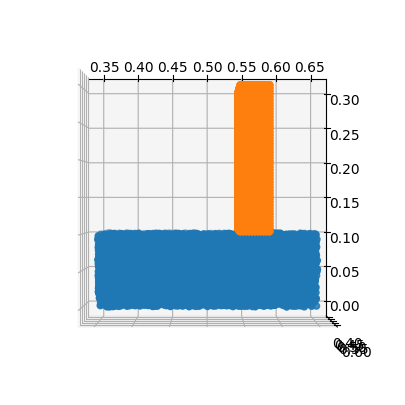

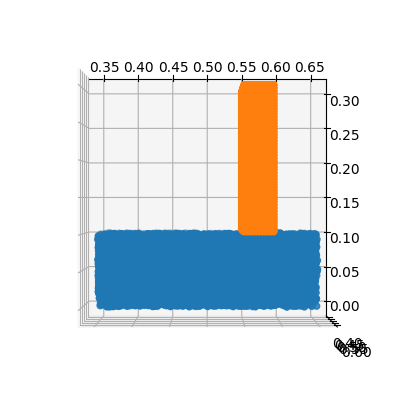

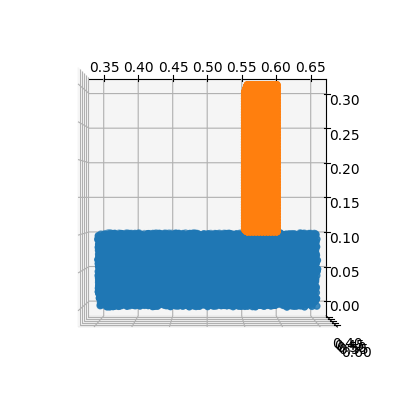

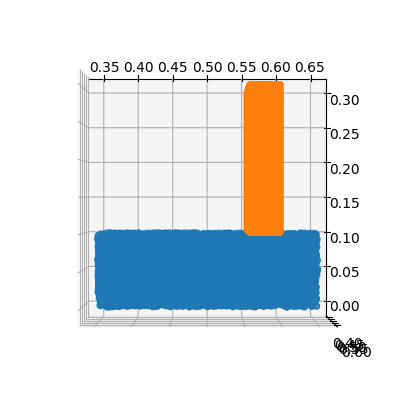

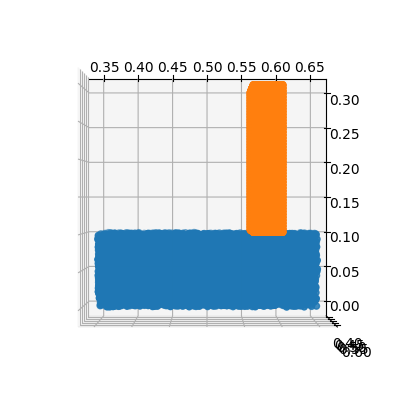

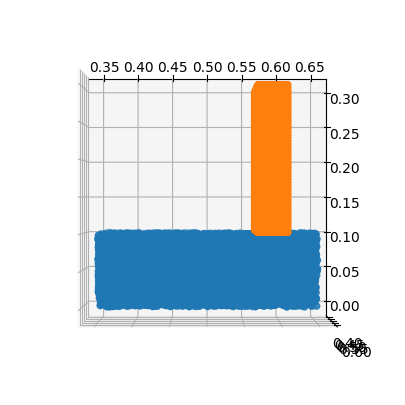

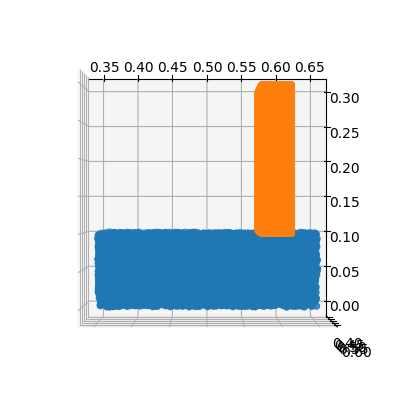

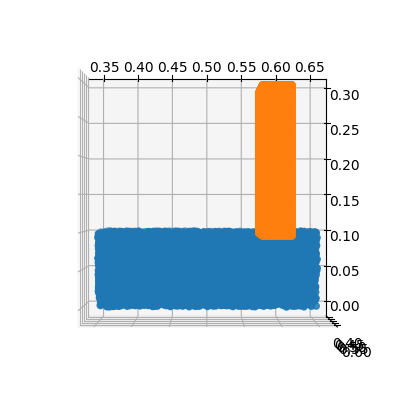

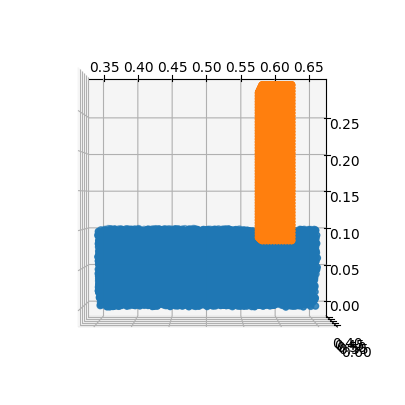

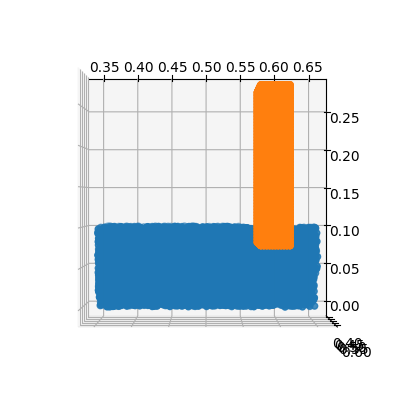

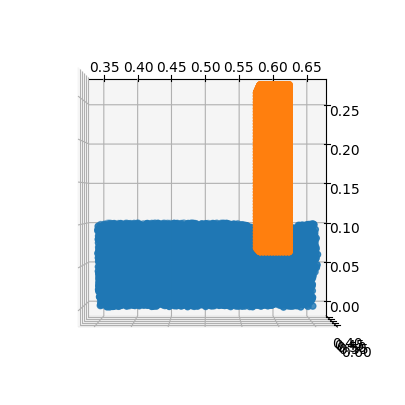

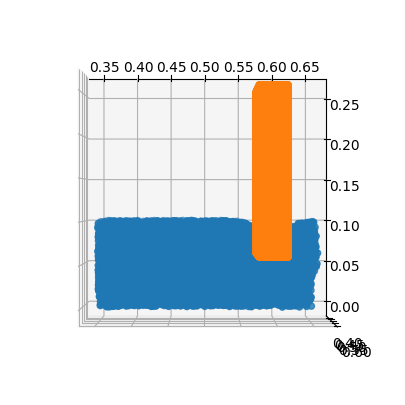

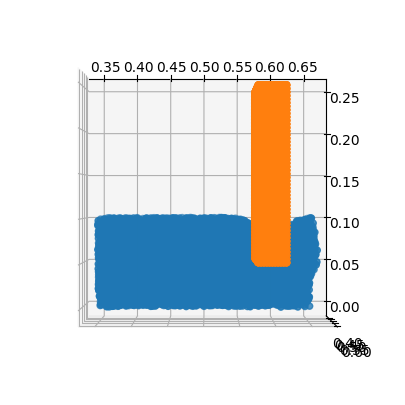

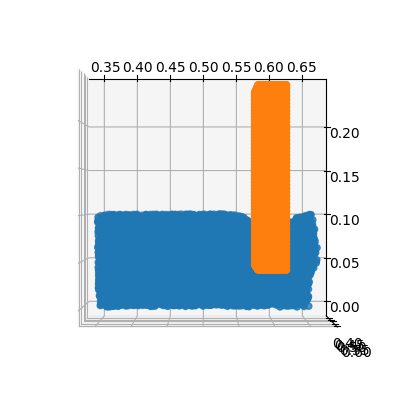

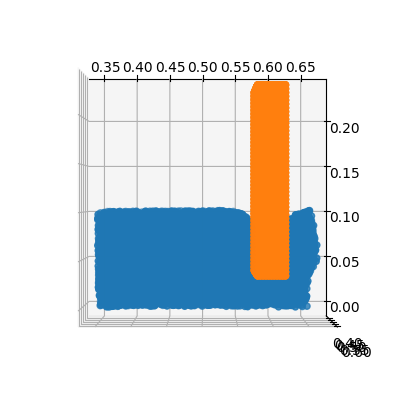

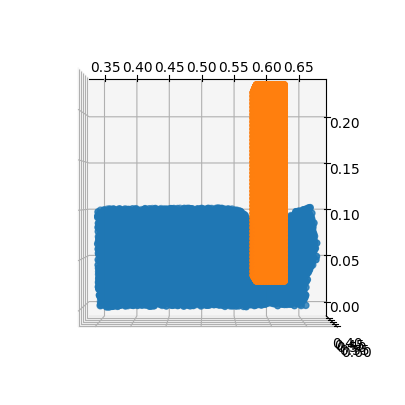

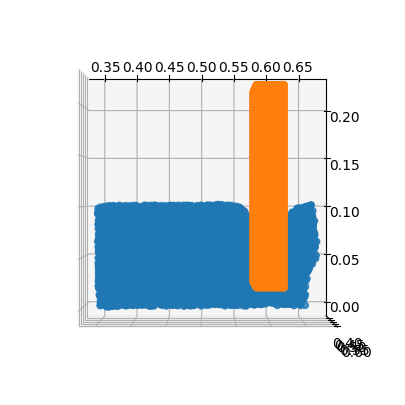

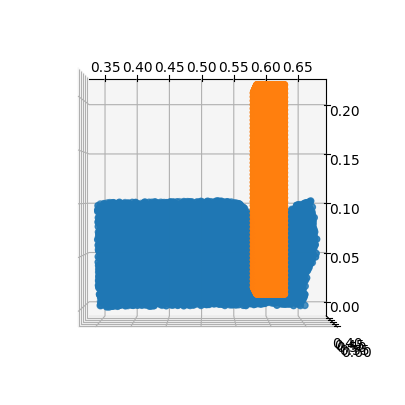

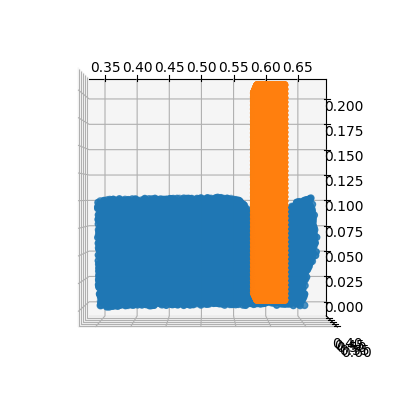

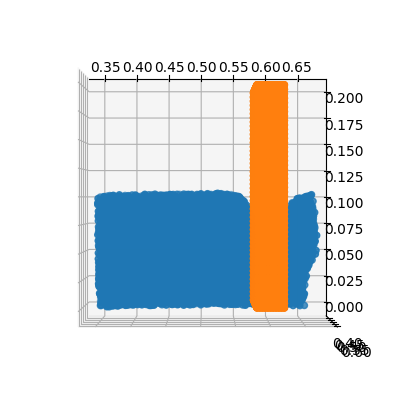

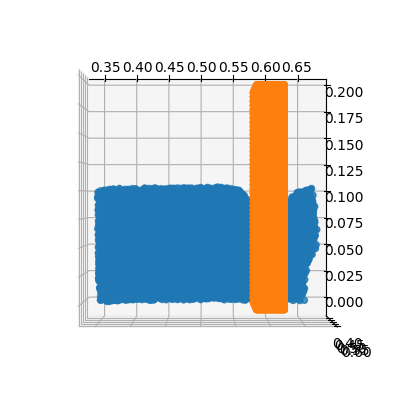

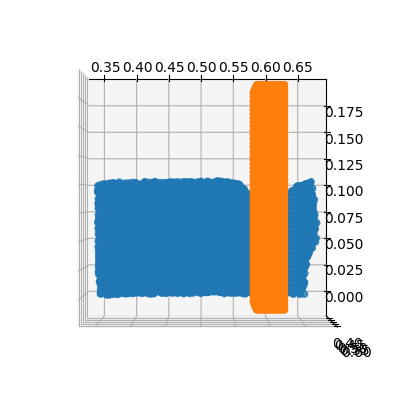

In [19]:
for i in range(100):
    if i == 0:
        continue
    pl_pc, pr_pc = data[i]
    goal_state = np.load(f'x.npy')
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pl_pc[:, 0], pl_pc[:, 1], pl_pc[:, 2])
    ax.scatter(pr_pc[:, 0], pr_pc[:, 1], pr_pc[:, 2])

    ax.view_init(90, 270)

In [1]:
import pickle
with open('/home/robot_dev4/kuroki/DMLC/policy/pbm/output/Rollingpin-v1/2023-02-27 08:09:34.042505/plasticine_pc_list_i.txt', 'rb') as f:
    pl_pc = np.array(pickle.load(f))
with open('/home/robot_dev4/kuroki/DMLC/policy/pbm/output/Rollingpin-v1/2023-02-27 08:09:34.042505/primitive_pc_list_i.txt', 'rb') as f:
    pr_pc = np.array(pickle.load(f))

NameError: name 'np' is not defined

In [11]:
import alphashape

alpha_shape = alphashape.alphashape(pr_pc[0], 0.1)
xx, yy = alpha_shape.exterior.coords.xy


AttributeError: 'Trimesh' object has no attribute 'exterior'

In [13]:
pr_pc[0].shape

(11387, 3)

In [ ]:
for i in range(100):
    goal_state = np.load(f'x.npy')
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pl_pc[i][:, 0], pl_pc[i][:, 1], pl_pc[i][:, 2])
    ax.scatter(pr_pc[i][:, 0], pr_pc[i][:, 1], pr_pc[i][:, 2])

    ax.view_init(90, 270)

In [7]:
import pickle
with open('/home/robot_dev4/kuroki/DMLC/policy/log/2023-02-26_12-30/2023-02-27_06-04/0_test_point_list.txt', 'rb') as f:
    data = pickle.load(f)

In [33]:
pl_pc = data['plasticine_pc']
pr_pc = data['primitive_pc']

In [ ]:

for i in range(100):
    goal_state = np.load(f'x.npy')
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pl_pc[i][:, 0], pl_pc[i][:, 1], pl_pc[i][:, 2])
    ax.scatter(pr_pc[i][:, 0], pr_pc[i][:, 1], pr_pc[i][:, 2])

    ax.view_init(90, 270)
 

In [ ]:
for i in range(100):
    goal_state = data[i]
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(goal_state[0][:, 0], goal_state[0][:, 1], goal_state[0][:, 2])
    ax.scatter(goal_state[1][:, 0], goal_state[1][:, 1], goal_state[1][:, 2])

    ax.view_init(90, 270)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(goal_state[:, 0], goal_state[:, 1], goal_state[:, 2])

In [ ]:
plt.scatter(goal_state[:, 0], goal_state[:, 1])

In [185]:
# goal_state = np.load(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/tasks/multi_bc_rope/imgs/v1500/goal_state.npy')
goal_state = np.load(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/tasks/two_roomba_one_rope/demo/v1/goal_state.npy')
goal_state = goal_state[:, [0, 2]]
base = np.array([0.5, 0.5])
ratio = 0.14980468749999978/0.40674225747442394
sim2pic_ratio = 0.001953125
origin = np.array([  72., 457.])
center = np.array([256., 256.])
goal_state -= base
goal_state = goal_state * np.array([1, -1])
goal_state = goal_state / ratio / sim2pic_ratio
goal_state += center
goal_state = goal_state * np.array([-1, 1])
goal_state = origin - goal_state

frame = cv2.imread(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/output/real/current/pose.jpg')

In [322]:
# goal_state = np.load(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/tasks/multi_bc_rope/imgs/v1500/goal_state.npy')
goal_state = np.load(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/tasks/two_roomba_one_rope/demo/v1/goal_state.npy')
goal_state = goal_state[:, [0, 2]]
sim2pic_ratio = 0.001953125
origin = np.array([-71, -451])
goal_state = goal_state / sim2pic_ratio
goal_state = np.array([goal_state[:, 1].tolist(), goal_state[:, 0].tolist()])
goal_state = np.transpose(goal_state, (1, 0))
goal_state = goal_state * np.array([1, -1])
goal_state = goal_state - origin
goal_state = [i.tolist() for i in goal_state if (i[0]>0) & (i[1]>0)]
goal_state = np.array(goal_state)

frame = cv2.imread(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/output/real/current/pose.jpg')

In [ ]:
plt.scatter(goal_state[:, 0], goal_state[:, 1])

In [324]:
goal_state = np.vstack([goal_state for _ in range(3)])
goal_state += np.random.normal(0, 4, goal_state.shape)
points = [(i[0], i[1]) for i in goal_state if i[0] > 200]
alpha_shape = alphashape.alphashape(points, 0.03)
xx, yy = alpha_shape.exterior.coords.xy
# xx= np.clip(xx, 0, 1e9)
# yy = np.clip(yy, 0, 1e9)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(frame)
# ax.scatter(goal_state[:, 0], goal_state[:, 1], marker="o", color="blue", s=450, alpha=0.005)
ax.plot(xx, yy, c='b', linewidth=3)
# ax.contour(xx, yy, [[0, 0] for _ in range(119)], marker="o", color="blue", s=450)

plt.show()

# real demo

In [7]:
from PIL import Image, ImageSequence
img = Image.open('/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/bc/jax_decision_transformer/dt_runs/bc_transformer_nearest_delay_0_multi_bc_rope_6/seed_0/22-10-11-13-09-42/model_3000_v1500_best/video_raw_2022-10-22 17:46:45.788249.gif')
frames = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in ImageSequence.Iterator(img)])

In [ ]:
goal_state = np.load(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/tasks/multi_bc_rope/imgs/v1500/goal_state.npy')
goal_state = goal_state[:, [0, 2]]
base = np.array([0.5, 0.5])
ratio = 0.14980468749999978/0.40674225747442394
sim2pic_ratio = 0.001953125
origin = np.array([  72., 457.])
center = np.array([256., 256.])
goal_state -= base
goal_state = goal_state * np.array([1, -1])
goal_state = goal_state / ratio / sim2pic_ratio
goal_state += center
goal_state = goal_state * np.array([-1, 1])
goal_state = origin - goal_state

imgs = []
for i in range(1):
    fig, ax = plt.subplots()
    ax.imshow(frames[i])
    ax.scatter(goal_state[:, 0], goal_state[:, 1], marker="o", color="blue", s=450, alpha=0.002)
    ax.axis('off')
    output_path = '/home/robot_dev4/kuroki/DifftaichiSim2Real/dummy.jpg'
    fig.savefig(output_path, bbox_inches='tight')
    video_array = cv2.imread(output_path)
    imgs.append(Image.fromarray(video_array))

In [15]:
# define a function which returns an image as numpy array from figure
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img


In [37]:
a = Image.fromarray(video_array)

In [38]:
a.show()

In [ ]:
# 1500, 1501, 1506, 1516
sim = [0.2016, 0.7653, 0.3463, 0.75]
real = [0.3069, 0.4844, 0.4375, 0.5969]
print('sim', np.mean(sim), np.std(sim))
print('real', np.mean(real), np.std(real))

# visualize

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
with open('/storage/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/output/multi_bc_rope_6/traj_1500_1549/multi_bc_rope_6-v1549_1_10000_traj.pickle', 'rb') as f:
    data = pickle.load(f)

particle_observe_size = 100
valid_data_length = 100

In [5]:
seg_size = data['goal_state'].shape[0]
step_size = int((seg_size/3) // particle_observe_size)

actions = data['action'][:valid_data_length]
rewards = data['rewards'][:valid_data_length]
goal_state_all = data['goal_state'].reshape(-1, 3)
goal_state = goal_state_all[::step_size, :]

# obs separate to rope and primitives
observations_base = data['observation'][:valid_data_length, :]
obs_reshape = observations_base[:, :seg_size*2].reshape(valid_data_length, -1, 3)
rope_xzy = obs_reshape[:, ::2, :][:, ::step_size, :]
obs_primitives = observations_base[:, seg_size*2:]

# primitives separate to primitive
primitive_xzy_list = []
for i in range(int(obs_primitives.shape[1]/7)):
    primitive_xzy = obs_primitives[:, i*7:(i+1)*7][:, :3]
    primitive_xzy_list.append(primitive_xzy)
primitives_xzy = np.concatenate(primitive_xzy_list, axis=1)

In [6]:
current = rope_xzy[0]
robot = primitives_xzy[0].reshape(-1, 3)

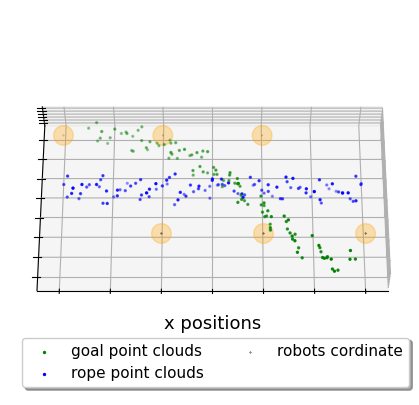

In [45]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = goal_state[:, 0], goal_state[:, 2], goal_state[:, 1]
ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))

# 軸ラベルを設定
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=0.0000000001)
ax.set_xlabel("x positions", fontsize=13)
ax.set_ylabel("y positions", fontsize=13)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(azim=90, elev=60)

ax.scatter(goal_state[:, 0], 1- goal_state[:, 2], goal_state[:, 1], c='green', s=2, label='goal point clouds')
ax.scatter(current[:, 0], 1- current[:, 2], current[:, 1], c='blue', s=2, label='rope point clouds')
robot[:, 1] = 0.02
ax.scatter(robot[:, 0], 1- robot[:, 2], robot[:, 1], c='orange', s=200, alpha=0.3)
ax.scatter(robot[:, 0], 1- robot[:, 2], robot[:, 1], c='black', s=0.1, label='robots cordinate')
plt.legend(loc='lower left', fontsize=11, bbox_to_anchor=(0.0, 0), ncol=2, fancybox=True, shadow=True)
plt.savefig('/storage/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/scripts/state.png')

'/storage/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/scripts'

# overlap

In [248]:
# bottom = cv2.imread(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/bc/jax_decision_transformer/dt_runs/bc_transformer_nearest_delay_0_multi_bc_rope_6/seed_0/best/model_3000_v1531_4_roomba_drag_3/frame_3748.png')
# top = cv2.imread(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/bc/jax_decision_transformer/dt_runs/bc_transformer_nearest_delay_0_multi_bc_rope_6/seed_0/best/model_3000_v1531_4_roomba_drag_3/frame_2505.png')
bottom = cv2.imread(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/bc/jax_decision_transformer/dt_runs/bc_transformer_nearest_delay_0_multi_bc_rope_6/seed_0/best/model_3000_v1531_4_roomba_drag_3/frame_1985.png')
top = cv2.imread(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/bc/jax_decision_transformer/dt_runs/bc_transformer_nearest_delay_0_multi_bc_rope_6/seed_0/best/model_3000_v1531_4_roomba_drag_3/frame_1454.png')

In [249]:
aaa = cv2.addWeighted(bottom,0.8,top,0.25,0)
a = Image.fromarray(aaa)
cv2.imwrite(f'goal.jpg', aaa)

True

In [2]:
# goal state

In [54]:
aaa = np.load('/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/tasks/multi_bc_rope/imgs/v1605/goal_state.npy')
# aaa = aaa[:1000]

In [ ]:
plt.scatter(aaa[:, 0], aaa[:, 2], marker="o", color="blue", s=450, alpha=0.05)

In [ ]:
plt.scatter(aaa[:, 0], aaa[:, 2], marker="o", color="blue", s=450, alpha=0.05)

In [ ]:
goal = np.load(f'/home/robot_dev4/kuroki/DifftaichiSim2Real/pbm/plb/envs/assets/multi_bc_rope-v1605.npy')
n_grid = 64
new_goal_state = []
for i in range(n_grid):
    for j in range(n_grid):
        for k in range(n_grid):
            if goal[i][j][k] > 0.0001:
                new_goal_state.append([i/n_grid, k/n_grid])
goal_state = np.array(new_goal_state)

plt.scatter(goal_state[:, 0], goal_state[:, 1], marker="o", color="blue", s=450, alpha=0.05)

In [ ]:
goal